In [1]:
# Imports:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

import matplotlib.pyplot as plt
from collections import Counter

In [2]:
df = pd.read_csv('Combined_SPA_Callback.csv')
df

,Date,ID,Text
0,26-Jul-17,1.010040e+11,please call daughter Dianne Thomas 07920 07565...
1,28-Jul-17,1.010040e+11,please speak to sister - Alyson Powell on abpv...
2,28-Jul-17,1.010040e+11,KELLY HAS RUNG - HER PARENTS ARE DUE TO HAVE W...
3,31-Jul-17,1.010040e+11,"Mark Hitchings, Scheme Manager Swn Yr Afon con..."
4,28-Jul-17,1.010040e+11,SON BRIAN HASFORD RUN G- HE IS RESIDENT IN AUS...
...,...,...,...
11353,13-Jun-23,1.010000e+11,"Enquiring about a downstairs toilet, states he..."
11354,13-Jun-23,1.010000e+11,Phoning on behalf on her mother she has no fee...
11355,13-Jun-23,1.010000e+11,States on saturday they had to call an ambulan...
11356,13-Jun-23,1.010000e+11,Nadia Obaji daughter of Abdel Obaji contacted ...


In [3]:
# Checking if a sentence is in caps:
def calculate_capital_percentage(string):
    total_letters = len(re.sub(r'[^a-zA-Z]', '', string))
    capital_letters = len(re.sub(r'[^A-Z]', '', string))
    capital_percentage = (capital_letters / total_letters) * 100
    return capital_percentage

# Function to clean text for NER:
def clean_text_for_NER(text):
    # Only keep Alphabets, Digits, Spaces, and Commonly Used Punctuations:
    text = re.sub(r'[^a-zA-Z0-9\s?,:"!.\']', '', text)
    # Remove extra spaces:
    text = re.sub(r'\s{2,}', ' ', text)
    text = text.strip()
    if calculate_capital_percentage(text) > 65:
        text = text.lower()
    return text

# Function to tokenize text:
def tokenize_text(text):
    # Tokenize sentences:
    sentences = sent_tokenize(text)
    # Tokenize words:
    words = []
    for sentence in sentences:
        words += word_tokenize(sentence)
    return words

# Function to remove stopwords:
def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return words

# Function to convert tokens into original text:
def words_to_text(words):
    current_text = ' '.join(words)
    return(current_text)

# Function to lemmatize words:
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word, tag in pos_tag(words):
        # Map POS tag to first letter used by WordNetLemmatizer:
        tag = tag[0].lower() if tag[0].lower() in ['a', 'r', 'n', 'v'] else wordnet.NOUN
        lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_words

# Function to stem words:
def stem_words(words):
    stemmer = PorterStemmer()
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words

# Function to perform NER:
def perform_ner(text):
    named_entities = ne_chunk(pos_tag(word_tokenize(text)))
    return named_entities

# Function to extract sentiment:
def extract_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

In [4]:
# Creating a list of sentences:
sentences = list(df["Text"])

# Clean the text
cleaned_data = [clean_text_for_NER(text) for text in sentences]

# Perform NER
ner_data = [perform_ner(text) for text in cleaned_data]

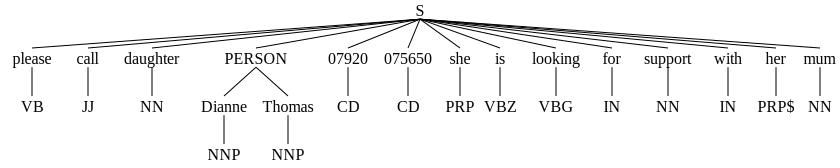

In [5]:
# Same example in an NER tree form:
ner_data[0]

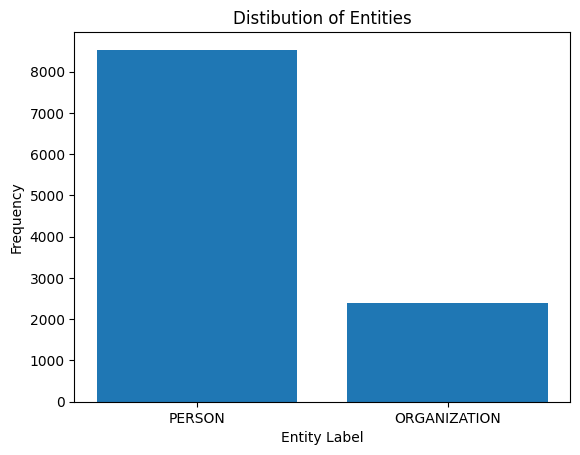

In [6]:
# Extract named entities and their labels:

organizations = []
persons = []
geopoliticals = []
locations = []
ner_stopwords = ["Please","PLEASE","URGENT","ONLY","ASAP","CALLBACK","CALL"]

entities = []
labels = []
for doc in ner_data:
    for chunk in doc:
        if hasattr(chunk, 'label'):
            flag = 0
            if chunk.label()=="ORGANIZATION":
                organization = ' '.join(c[0] for c in chunk)
                if organization not in ner_stopwords:
                    organizations.append(organization)
                    flag = 1 
            elif chunk.label()=="PERSON":
                person = ' '.join(c[0] for c in chunk)
                if len(person)>2 and person not in ner_stopwords:
                    persons.append(' '.join(c[0] for c in chunk))
                    flag = 1
            if flag == 1:
                entities.append(' '.join(c[0] for c in chunk))
                labels.append(chunk.label())

# Count the frequency of each label:
label_counts = Counter(labels)

# Plot the frequency of each label:
plt.bar(label_counts.keys(), label_counts.values())
plt.title('Distibution of Entities')
plt.xlabel('Entity Label')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Tokenize text
tokenized_data = [tokenize_text(text) for text in cleaned_data]

# Remove stopwords
no_stopwords_data = [remove_stopwords(words) for words in tokenized_data]

# Lemmatize words
lemmatized_data = [lemmatize_words(words) for words in no_stopwords_data]

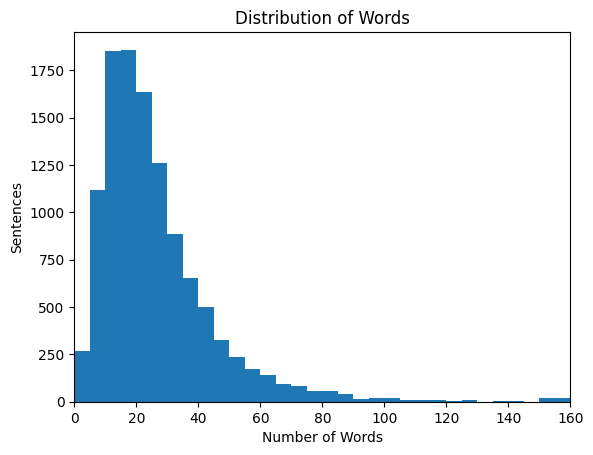

In [8]:
# Calculating number of
no_of_tokens = [len(sentence) for sentence in lemmatized_data]
bin_width = 5
threshold = 150

# Calculate the bin edges:
bins = list(range(min(no_of_tokens)-1, threshold + bin_width, bin_width)) + [max(no_of_tokens) + bin_width]

# Plotting the distribution as a histogram:
plt.hist(no_of_tokens, bins=bins)
plt.xlabel('Number of Words')
plt.ylabel('Sentences')
plt.title('Distribution of Words')

# Setting x-axis limits and showing plot:
plt.xlim(0, 160)
plt.show()

In [9]:
# Sort by rank (most common to least common)
sorted_counter = sorted(Counter(organizations).items(), key=lambda x: x[1], reverse=True)
print("Top 10 most common occurences of Organizations/ Products:")
for item, count in sorted_counter[:10]:
    print('{}: {}'.format(item,count))
    
# Sort by rank (most common to least common)
sorted_counter = sorted(Counter(persons).items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 most common occurences of Persons:")
for item, count in sorted_counter[:10]:
    print('{}: {}'.format(item,count))

Top 10 most common occurences of Organizations/ Products:
GP: 74
FAO: 63
SPA: 61
COPD: 60
RGH: 54
WCCIS: 53
NHS: 45
Social Services: 42
OT: 27
DFG: 27

Top 10 most common occurences of Persons:
Client: 486
Daughter: 166
Son: 133
Rachel Thomas: 121
Jones: 88
Sally Prosser: 72
Trivallis: 60
Williams: 57
David: 49
Helen: 45
